# DQN Agent

In cases where the number of possible states becomes very large it becomes computationally inefficient to store the Q Values for each state in a table.

To overcome this we use a Neural Network as a function approximator. We pass the input state and action to the network and retrieve the approximated Q Value.

Since Q Learning is an Off policy algorithm it is able to learn from old experiences. We create a simple buffer using a deque that stores the last 200 frames. At each timestep we sample from the buffer for training.


In [1]:
import gym
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import gym
import numpy as np
import tensorflow as tf
from collections import deque
%matplotlib inline

### Visualize random agent

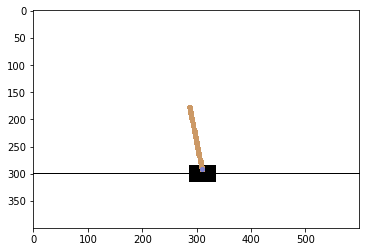

Times steps survivied when using a Random Agent:  16.0


In [2]:
# Please note to render the Cart Pole Environment on a remote server you need to run the jupyter notebook using a virtual display.
# Use the following command
# xvfb-run -a -s "-screen 0 1400x900x24 +extension RANDR" -- jupyter notebook --no-browser

env = gym.make("CartPole-v1")

state = env.reset()
done = False
total_reward = 0
while not done:
    clear_output(wait = True)
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    time.sleep(.1)
    total_reward += reward
print("Times steps survivied when using a Random Agent: ", total_reward)

### Building the Network

In [3]:

EPISODES = 50

class DQAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = .95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.001
        
        with tf.variable_scope("DQNetwork"):
            self.inputs_ = tf.placeholder(tf.float32, 
                                         [None, state_size], 
                                         name="inputs")
            self.actions_ = tf.placeholder(tf.float32,
                                          action_size,
                                          name="actions")
            self.target_Q = tf.placeholder(tf.float32,
                                          (),
                                          name="target_q")
            
            self.fc1 = tf.layers.dense(inputs=self.inputs_,
                                      units=24,
                                      activation=tf.nn.elu,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      name="fc1"
                                      )
            
            self.fc2 = tf.layers.dense(inputs=self.fc1,
                                      units=24,
                                      activation=tf.nn.elu,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      name="fc2")
            
            self.output = tf.layers.dense(inputs=self.fc2,
                                         units = action_size,
                                         activation=None,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                         name="output")
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
            
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, sess):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            act_values = sess.run(self.output, feed_dict={
                self.inputs_ : state
            })
            return np.argmax(act_values)

    def replay(self, batch_size, sess):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target_q = sess.run(self.output, feed_dict={
                    self.inputs_ : next_state
                })
                target = (reward + self.gamma * np.amax(target_q[0]))
            #Remove incorrect indent, we want to train at each timestep not just when it is done
            action = np.eye(self.action_size)[action]

            loss, _ = sess.run([self.loss, self.optimizer], feed_dict={
                self.inputs_ : state,
                self.target_Q : target,
                self.actions_ : action
            })


            

### Train Agent

In [4]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

tf.reset_default_graph()
agent = DQAgent(state_size, action_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
done = False
batch_size = 32

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, (1, state_size))
    for time in range(200):
        action = agent.act(state, sess)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, (1, state_size))
        reward = reward if not done else -10.0
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if len(agent.memory)> batch_size:
            agent.replay(batch_size, sess)
            if agent.epsilon > agent.epsilon_min:
                agent.epsilon *= agent.epsilon_decay
        if done:
            break
    print(f"episode {e}, score: {time}, e: {agent.epsilon}")

    

episode 0, score: 12, e: 1.0
episode 1, score: 16, e: 1.0
episode 2, score: 14, e: 0.9870777147137147
episode 3, score: 16, e: 0.9704309672630859
episode 4, score: 10, e: 0.959809440525076
episode 5, score: 11, e: 0.9483548639781193
episode 6, score: 26, e: 0.9230793978373364
episode 7, score: 11, e: 0.9120631656822724
episode 8, score: 19, e: 0.8939941590229386
episode 9, score: 20, e: 0.8754068367770318
episode 10, score: 62, e: 0.8219316276865206
episode 11, score: 25, e: 0.8008264083574369
episode 12, score: 13, e: 0.7896874231428072
episode 13, score: 21, e: 0.7724955072656065
episode 14, score: 14, e: 0.7609888362515699
episode 15, score: 13, e: 0.750403966288439
episode 16, score: 59, e: 0.7066826263699144
episode 17, score: 30, e: 0.6851009179515178
episode 18, score: 51, e: 0.6503691570122084
episode 19, score: 27, e: 0.632402542800493
episode 20, score: 76, e: 0.5855125400671733
episode 21, score: 95, e: 0.531891525167934
episode 22, score: 109, e: 0.47646036099556505
episode

### Evaluating Agent

In [5]:
agent.epsilon = 0.0
episodes = 100

total_reward = 0
for _ in range(episodes):
    state = env.reset()
    done = False
    while not done:
        state = np.reshape(state, (1, state_size))
        action = agent.act(state, sess)
        state, reward, done, _ = env.step(action)
        total_reward += reward

print(f"Results after {episodes} episodes:")
print(f"Average Reward per episode: {total_reward / episodes}")

Results after 100 episodes:
Average Reward per episode: 290.11


In [6]:
sess.close()